In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression, LassoLars, lars_path, lasso_path
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

In [362]:
df = pd.read_csv('data/fullExpandedData.csv')
df['date'] = pd.to_datetime(df['date'])
date = df['date']
dates = date[0:3000]
cvDate = date[3000:4347-2]
df = df.drop(['date'], axis=1)
df = df.dropna()
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df[0:4347])
df_normalized = pd.DataFrame(np_scaled)
df_normalized.columns = ['pna','ao','soi','dxs','dD','unc','dO','unc.1','amount [mL]']

In [363]:
print(df_normalized)

           pna        ao       soi       dxs        dD       unc        dO  \
0     0.354226  0.824971  0.443739  0.562163  0.781467  0.084246  0.661591   
1     0.350337  0.722064  0.384049  0.578363  0.740056  0.102825  0.622333   
2     0.374570  0.599297  0.325057  0.594563  0.698645  0.121405  0.583075   
3     0.386088  0.535158  0.348044  0.610763  0.657234  0.139985  0.543818   
4     0.382049  0.553402  0.324422  0.626962  0.615823  0.158565  0.504560   
5     0.402693  0.590555  0.342139  0.643162  0.574412  0.177145  0.465302   
6     0.462678  0.623242  0.374905  0.659362  0.533001  0.195725  0.426044   
7     0.521765  0.659065  0.426022  0.675562  0.491590  0.214305  0.386787   
8     0.557367  0.642721  0.387986  0.675104  0.501955  0.204100  0.395623   
9     0.579058  0.542569  0.319215  0.674646  0.512320  0.193895  0.404458   
10    0.593119  0.450019  0.303467  0.674189  0.522685  0.183690  0.413294   
11    0.596410  0.406404  0.429324  0.673731  0.533050  0.173485

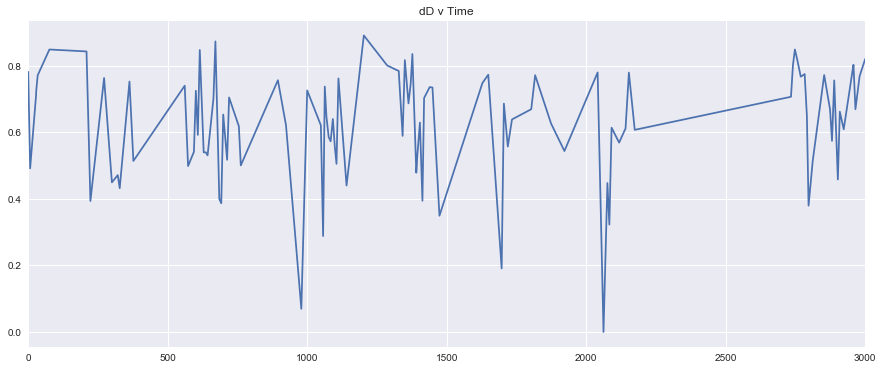

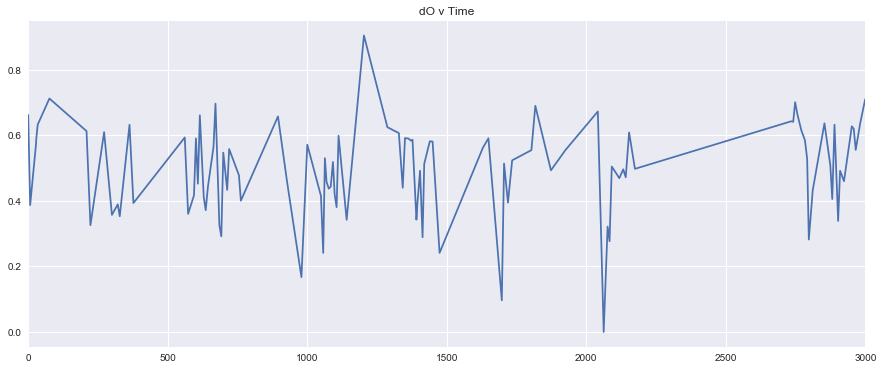

In [364]:
df_normalized.dD.loc[0:3000].plot(figsize=(15,6), title='dD v Time')
plt.show()
df_normalized.dO[0:3000].plot(figsize=(15,6), title='dO v Time')
plt.show()

In [365]:
#Low p-value indicates a stationary time series
pvalue = adfuller(df_normalized.dD[0:3000])[1]
pvalue

3.1102017614234933e-09

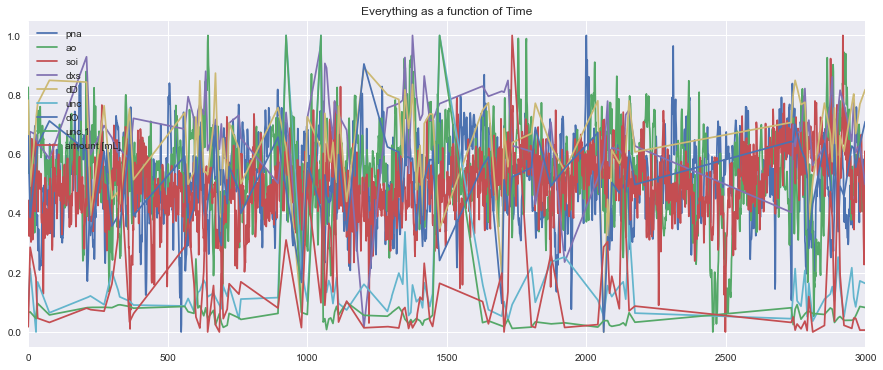

In [366]:
df_normalized[0:3000].plot(
    figsize=(15,6), title='Everything as a function of Time')
plt.show()

In [367]:
y = df_normalized['dD']
selected_predictors = df_normalized[['pna', 'ao', 'soi', 'dxs', 'unc', 'unc.1', 'amount [mL]']]
print(df_normalized.shape)
#they're all stationary!
for x in selected_predictors.columns:
    print('ADF test p-value on %s:' % x, adfuller(selected_predictors[x].dropna())[1])

(4345, 9)
ADF test p-value on pna: 1.18330857822e-28
ADF test p-value on ao: 9.22217667429e-23
ADF test p-value on soi: 1.01825847255e-09
ADF test p-value on dxs: 1.59724921526e-05
ADF test p-value on unc: 8.31620352923e-08
ADF test p-value on unc.1: 3.81592144715e-08
ADF test p-value on amount [mL]: 5.64008301702e-12


In [368]:
def regress(predictor, response, start, end, halflife, returnr2=False, outlier_cap=2):
    '''
        helper function to run regression
        predictor: dataframe of predictors
        response: series of response
        start: start date
        end: end date
        halflife: halflife to weight regression exponentially
    '''
    y = response[start:end].values
    X = predictor[start:end].values
    
    # cap both y and X at 2 standard deviations to avoid heavy influence of outliers
    y = np.clip(y, -outlier_cap * np.std(y), outlier_cap * np.std(y))
    X = np.clip(X, -outlier_cap * np.std(X, axis=0), outlier_cap * np.std(X, axis=0))
    
    assert X.shape[0] == y.shape[0], "predictor and response are not the same length"
    
    w = np.ones(y.shape)
    decay = 2.0 ** (-1.0/halflife)
    for i in range(len(w)-2, -1, -1):
        w[i] = w[i+1] * decay
    
    reg = LinearRegression(normalize=True)
    reg.fit(X, y, sample_weight=w)
    if returnr2:
        return (reg, reg.score(X,y))
    return reg

In [369]:
# Rolling regression

regression_window = 50
regression_halflife = 50

reg = np.empty(3000, dtype=object)
for t in range(regression_window, 3000):
    reg[t] = regress(selected_predictors, df_normalized['dD'], t-regression_window, t, regression_halflife)
regobj = pd.Series(reg[regression_window:], index=dates[regression_window:], name='regress_object')

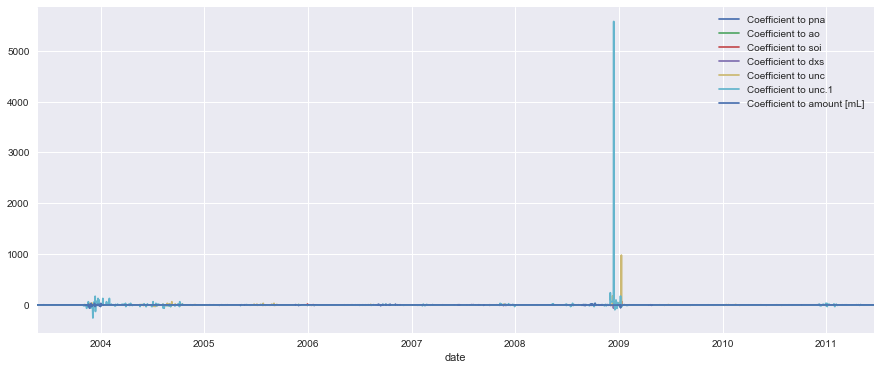

In [370]:
plt.figure(figsize=(15,6))
regobj.map(lambda x: x.coef_[0]).plot(label='Coefficient to pna')
regobj.map(lambda x: x.coef_[1]).plot(label='Coefficient to ao')
regobj.map(lambda x: x.coef_[2]).plot(label='Coefficient to soi')
regobj.map(lambda x: x.coef_[3]).plot(label='Coefficient to dxs')
regobj.map(lambda x: x.coef_[4]).plot(label='Coefficient to unc')
regobj.map(lambda x: x.coef_[5]).plot(label='Coefficient to unc.1')
regobj.map(lambda x: x.coef_[6]).plot(label='Coefficient to amount [mL]')
plt.legend()
plt.show()

In [371]:
#cross validation period
df = pd.concat([pd.Series(cvDate, index=regobj.index, name='date'), regobj], axis=1).shift(1).dropna()
print(selected_predictors)

prediction = df.apply(lambda x: x.regress_object.predict(selected_predictors.loc[x.date].values.reshape(1,-1)), 
                      axis=1)['date']
prediction = prediction.rename('predicted').rename_axis('date')

           pna        ao       soi       dxs       unc     unc.1  amount [mL]
0     0.354226  0.824971  0.443739  0.562163  0.084246  0.065079     0.017637
1     0.350337  0.722064  0.384049  0.578363  0.102825  0.065445     0.055945
2     0.374570  0.599297  0.325057  0.594563  0.121405  0.065812     0.094252
3     0.386088  0.535158  0.348044  0.610763  0.139985  0.066179     0.132560
4     0.382049  0.553402  0.324422  0.626962  0.158565  0.066545     0.170867
5     0.402693  0.590555  0.342139  0.643162  0.177145  0.066912     0.209175
6     0.462678  0.623242  0.374905  0.659362  0.195725  0.067278     0.247482
7     0.521765  0.659065  0.426022  0.675562  0.214305  0.067645     0.285790
8     0.557367  0.642721  0.387986  0.675104  0.204100  0.066575     0.280836
9     0.579058  0.542569  0.319215  0.674646  0.193895  0.065506     0.275882
10    0.593119  0.450019  0.303467  0.674189  0.183690  0.064437     0.270928
11    0.596410  0.406404  0.429324  0.673731  0.173485  0.063367

In [329]:
# Rolling regression

regression_window = 50
regression_halflife = 50

reg = np.empty(df_normalized.shape[0]-3000, dtype=object)
for t in range(3000+regression_window, df_normalized.shape[0]):
    reg[t-3000] = regress(selected_predictors, df_normalized['dD'], t-regression_window, t, regression_halflife)
regobj = pd.Series(reg[regression_window:], index=cvDate[regression_window:], name='regress_object')

AttributeError: 'list' object has no attribute 'values'

In [302]:
print(prediction)


(0,)
